In [1]:
import sys
sys.path.insert(0, "../source/")
import pyomo

# Pyomo DAE

In [26]:
import numpy as np
import pyomo.environ as pyenv
from scipy.integrate import RK45


model = pyenv.ConcreteModel()

x0 = 0.8
y0 = 0.5
theta0 = 0.0
x_final = 0.0
y_final = 0.0
theta_final = np.pi

# bounds
x_lower = 0
x_upper = 1
y_lower = 0
y_upper = 1
v_lower = 0
v_upper = 10
omega_lower = -100*np.pi
omega_upper = 100*np.pi

model.T = 4  # final time
model.NK = 1000  # number of time steps
model.h = model.T/model.NK  # time grid spacing
model.K = pyenv.RangeSet(model.NK)
model.K0 = pyenv.RangeSet(0, model.NK)
model.Km1 = pyenv.RangeSet(model.NK - 1)  # [1, NK - 1]
model.K0m1 = pyenv.RangeSet(0, model.NK - 1)  # [1, NK - 1]

initial_x = np.linspace(x0, 0.2, model.NK)
initial_y = np.linspace(y0, 0.0, model.NK)
initial_theta = np.linspace(0.2, 0.5, model.NK)
initial_v = np.ones(initial_x.shape)

model.x = pyenv.Var(model.K0, domain=pyenv.Reals, bounds=(x_lower, x_upper), initialize=dict(zip(model.K0, initial_x))) # p(t)_x
model.y = pyenv.Var(model.K0, domain=pyenv.Reals, bounds=(y_lower, y_upper), initialize=dict(zip(model.K0, initial_y))) # p(t)_y
model.theta = pyenv.Var(model.K0, domain=pyenv.Reals)  # theta can be unbounded, arctan(dy/dx)
model.v = pyenv.Var(model.K0, domain=pyenv.Reals, bounds=(v_lower, v_upper), initialize=dict(zip(model.K0, initial_v))) # velocity; control parameter
model.omega = pyenv.Var(model.K0, domain=pyenv.Reals, bounds=(omega_lower, omega_upper)) # angular velocity; control parameter

def x_forward_Euler(model, k):
    return model.x[k + 1] - model.x[k] == model.h * model.v[k] * pyenv.cos(model.theta[k])
model.x_forward_Euler = pyenv.Constraint(model.K0m1, rule=x_forward_Euler)

def y_forward_Euler(model, k):
    return model.y[k + 1] - model.y[k] == model.h * model.v[k] * pyenv.sin(model.theta[k])
model.y_forward_Euler = pyenv.Constraint(model.K0m1, rule=y_forward_Euler)

def theta_forward_Euler(model, k):
    return model.theta[k + 1] - model.theta[k] == model.h * model.omega[k]
model.theta_forward_Euler = pyenv.Constraint(model.K0m1, rule=theta_forward_Euler)

def initial_x_rule(model):
    return model.x[0] == x0
model.initial_x_rule = pyenv.Constraint(rule=initial_x_rule)

def initial_y_rule(model):
    return model.y[0] == y0
model.initial_y_rule = pyenv.Constraint(rule=initial_y_rule)

def initial_theta_rule(model):
    return model.theta[0] == theta0
# model.initial_theta_rule = pyenv.Constraint(rule=initial_theta_rule)

def final_x_rule(model):
    return model.x[model.NK] == x_final
model.final_x_rule = pyenv.Constraint(rule=final_x_rule)

def final_y_rule(model):
    return model.y[model.NK] == y_final
model.final_y_rule = pyenv.Constraint(rule=final_y_rule)

# Allow for +- 2*pi
def final_theta_sin_rule(model):
    return pyenv.sin(model.theta[model.NK]) == pyenv.sin(theta_final)

def final_theta_cos_rule(model):
    return pyenv.cos(model.theta[model.NK]) == pyenv.cos(theta_final)

# model.final_theta_sin_rule = pyenv.Constraint(rule=final_theta_sin_rule)
# model.final_theta_cos_rule = pyenv.Constraint(rule=final_theta_cos_rule)


cx = 0.5
cy = 0.5
r = 0.25

def circle_obstacle_rule_constructor(cx, cy, r, x_var, y_var):
    def circle_obstacle_rule(model, k):
        """circle obstacle with center"""
        return (x_var[k] - cx)**2 + (y_var[k] - cy)**2 >= r**2
    return circle_obstacle_rule
model.circle_obstacle_rule = pyenv.Constraint(model.K0, rule=circle_obstacle_rule_constructor(cx, cy, r, model.x, model.y))

def objective_func(model):
    return model.x[model.NK]**2 + model.y[model.NK]**2 + 0.01/model.NK*(pyenv.sum_product(model.v, model.v) + pyenv.sum_product(model.omega, model.omega))
    # return pyenv.sum_product(model.v, model.v) + pyenv.sum_product(model.omega, model.omega)
model.objective_func = pyenv.Objective(rule=objective_func, sense=pyenv.minimize)


solver = pyenv.SolverFactory("ipopt")
solver.solve(model, tee=True)

Ipopt 3.14.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    11004
Number of nonzeros in inequality constraint Jacobian.:     2002
Number of nonzeros in Lagrangian Hessian.............:     6004

Total number of variables............................:     5005
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     4004
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3004
Total number

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 4005, 'Number of variables': 5005, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.12\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 14.513087511062622}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

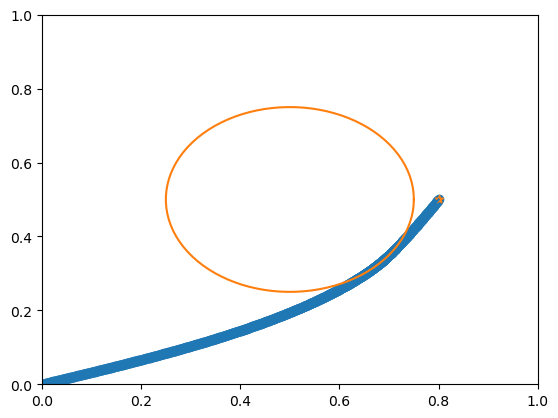

In [27]:
import matplotlib.pyplot as plt
plt.figure()

x, y, theta, v, omega = [], [], [], [], []
for k in zip(model.K0):
    x.append(pyenv.value(model.x[k]))
    y.append(pyenv.value(model.y[k]))
    theta.append(pyenv.value(model.theta[k]))
    v.append(pyenv.value(model.v[k]))
    omega.append(pyenv.value(model.omega[k]))
plt.plot(x, y)
plt.scatter(x, y)
plt.scatter(x[0], y[0], marker='*')
plt.xlim([-0,1])
plt.ylim([-0,1])

t = np.linspace(0, 2*np.pi, 100)
plt.plot(r*np.cos(t) + cx, r*np.sin(t) + cy)